In [102]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time

In [103]:
folder_path = './'
subfolder_path = 'middle_and_ducks/'
save_folder = 'graph/student'

img_size = 101
l2_alpha = 1e-2
l2_regularizer = False
save_mode = True

num_epochs = 100
batch_size = 512
lr = 0.00005

L2_LAMBDA = 0.01


def _residual_block(x, size, dropout=False, dropout_prob=0.5, seed=None):
    residual = tf.layers.batch_normalization(x)  # TODO: check if the defaults in Tf are the same as in Keras
    residual = tf.nn.relu(residual)
    residual = tf.layers.conv2d(residual, filters=size, kernel_size=3, strides=2, padding='same',
                                kernel_initializer=tf.keras.initializers.he_normal(seed=seed),
                                kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA))
    if dropout:
        residual = tf.nn.dropout(residual, dropout_prob, seed=seed)
    residual = tf.layers.batch_normalization(residual)
    residual = tf.nn.relu(residual)
    residual = tf.layers.conv2d(residual, filters=size, kernel_size=3, padding='same',
                                kernel_initializer=tf.keras.initializers.he_normal(seed=seed),
                                kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA))
    if dropout:
        residual = tf.nn.dropout(residual, dropout_prob, seed=seed)

    return residual


def one_residual(x, keep_prob=0.5, seed=None):
    nn = tf.layers.conv2d(x, filters=32, kernel_size=5, strides=2, padding='same',
                          kernel_initializer=tf.keras.initializers.he_normal(seed=seed),
                          kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA))
    nn = tf.layers.max_pooling2d(nn, pool_size=3, strides=2)

    rb_1 = _residual_block(nn, 32, dropout_prob=keep_prob, seed=seed)

    nn = tf.layers.conv2d(nn, filters=32, kernel_size=1, strides=2, padding='same',
                          kernel_initializer=tf.keras.initializers.he_normal(seed=seed),
                          kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA))
    nn = tf.keras.layers.add([rb_1, nn])

    nn = tf.layers.flatten(nn)

    return nn

In [104]:
train_image, train_label, test_image, test_label = [], [], [], []

with open(folder_path + subfolder_path + 'train.txt', 'r') as f:
    temp = [l.split(' ') for l in f.read().splitlines()]
f.close()

for l in temp:
    img = cv2.imread(folder_path + l[0])
    train_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
    train_label.append(l[1])

with open(folder_path + subfolder_path + 'test.txt', 'r') as f:
    temp = [l.split(' ') for l in f.read().splitlines()]
f.close()

for l in temp:
    img = cv2.imread(folder_path + l[0])
    test_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
    test_label.append(l[1])

train_label = np.array(train_label).astype(np.int)
test_label = np.array(test_label).astype(np.int)

picture_train = (np.array(train_image).astype(np.float32) - 127.5) / 127.5
picture_test = (np.array(test_image).astype(np.float32) - 127.5) / 127.5

train_label_one_hot = np.zeros((len(train_label), 15)).astype(np.int32)
test_label_one_hot = np.zeros((len(test_label), 15)).astype(np.int32)
for i in range(len(train_label)):
    train_label_one_hot[i, train_label[i]] = 1
for i in range(len(test_label)):
    test_label_one_hot[i, test_label[i]] = 1

In [105]:
# plt.hist(train_label, bins=15)
# plt.show()

In [106]:
# #img = tf.Variable(train_image[:2]) # img shape is [580,580,3]
# img = tf.placeholder(dtype=tf.float32,shape=[None, img_size, img_size, 3], name='input')
# #b = tf.image.crop_and_resize(img,[[0.5,0.1,0.9,0.5]],[0],[50,50])
# c = tf.image.crop_to_bounding_box(
#     image = img,
#     offset_height = 40,
#     offset_width = 0,
#     target_height = 61,
#     target_width = 101
# )
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# #a = c.eval(session=sess)
# a = sess.run(c, feed_dict={img: train_image})
# plt.imshow(a[1].astype(int))
# #plt.imshow(a[1])
# print(a.shape)

In [107]:
tf.reset_default_graph()
pic_placehold = tf.placeholder(dtype=tf.float32,shape=[None, img_size, img_size, 3], name='input')
out_placehold = tf.placeholder(tf.int32, [None, 15])
x = tf.image.crop_to_bounding_box(
    image = pic_placehold,
    offset_height = 40,
    offset_width = 0,
    target_height = 61,
    target_width = 101
)

x = one_residual(x, seed=1234)
x = tf.layers.dense(x, units=64, activation=tf.nn.relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1234),
                                bias_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1234))
x = tf.layers.dense(x, units=32, activation=tf.nn.relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1234),
                                bias_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1234))

x = tf.layers.dense(x, units = 15)



# # x = tf.layers.conv2d(pic_placehold, 64, 3, strides=3, padding='valid')
# # x = tf.nn.relu(x)
# # x = tf.layers.batch_normalization(x)
# x = tf.layers.conv2d(x, 64, 3, strides=3, padding='valid')
# x = tf.nn.relu(x)
# x = tf.nn.max_pool(x, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
# # x = tf.layers.batch_normalization(x)
# x = tf.reshape(x, [-1, int(x.shape[1]) * int(x.shape[2]) * int(x.shape[3])])
# x = tf.layers.dense(x, units = 32, trainable=True, use_bias=True)
# x = tf.nn.relu(x)
# x = tf.layers.dense(x, units = 15, trainable=True, use_bias=True)
pred = x
output1 = tf.nn.softmax(x, name='output')
output = tf.math.argmax(output1, axis=1)



In [108]:
values, counts = np.unique(train_label, return_counts = True)
print(values)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 62   9   7  16  38  47  92 600 254 182 124 115 101  71 229]


In [109]:
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)
ratio = counts*(1/np.sum(counts))

class_weight = 1.0 - ratio

weight_per_label = tf.transpose(tf.matmul(tf.dtypes.cast(out_placehold, tf.float32), tf.expand_dims(tf.dtypes.cast(tf.transpose(class_weight), tf.float32), 1)))
print(weight_per_label.shape)

xent = tf.multiply(weight_per_label, tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)) 
cross_entropy = tf.reduce_mean(xent) #shape 1

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)
# cross_entropy = tf.contrib.losses.softmax_cross_entropy(logits=pred, out_placehold, weight=weight)
var = tf.trainable_variables()
if l2_regularizer:
     lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in var if 'kernel' in v.name]) * l2_alpha
     cost = lossL2 + tf.reduce_mean(cross_entropy)
cost = tf.reduce_mean(cross_entropy)
prediction = tf.argmax(pred, 1)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold))
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(out_placehold, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

(1, ?)


In [110]:
sess = tf.Session()
if save_mode:
    saver = tf.train.Saver()
init = tf.global_variables_initializer()
sess.run(init)

tmp_loss, tmp_acc = None, None
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
for i in range(num_epochs):
        x_bar_imag, y_bar = shuffle(picture_train, train_label_one_hot)
        for batch in range(len(x_bar_imag) // batch_size):
            batch_x = x_bar_imag[batch * batch_size:min((batch + 1) * batch_size, len(x_bar_imag))]
            batch_y = y_bar[batch * batch_size:min((batch + 1) * batch_size, len(y_bar))]    
            opt = sess.run(optimizer, feed_dict={pic_placehold:batch_x, out_placehold:batch_y})
            tmp_loss, tmp_acc = sess.run([cost, accuracy], feed_dict={pic_placehold:batch_x, out_placehold:batch_y})
        train_loss.append(tmp_loss)
        train_acc.append(tmp_acc)
        loss, acc = sess.run([cost, accuracy], feed_dict={pic_placehold:picture_test, out_placehold:test_label_one_hot})
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(('Iter {0:02d} --- Loss = {1:02.3f} --- Acc = {2:02.2f} --- Val Loss = {3:02.3f} --- Val Acc = {4:02.2f}').format(i, tmp_loss, tmp_acc * 100, valid_loss[i], valid_acc[i] * 100))

if save_mode:
    save_path = saver.save(sess, save_folder)

Iter 00 --- Loss = 2.764 --- Acc = 4.88 --- Val Loss = 2.662 --- Val Acc = 3.24
Iter 01 --- Loss = 2.566 --- Acc = 12.30 --- Val Loss = 2.476 --- Val Acc = 13.89
Iter 02 --- Loss = 2.456 --- Acc = 20.70 --- Val Loss = 2.316 --- Val Acc = 30.56
Iter 03 --- Loss = 2.430 --- Acc = 24.61 --- Val Loss = 2.164 --- Val Acc = 42.59
Iter 04 --- Loss = 2.390 --- Acc = 25.78 --- Val Loss = 2.037 --- Val Acc = 52.31
Iter 05 --- Loss = 2.404 --- Acc = 25.39 --- Val Loss = 1.949 --- Val Acc = 54.63
Iter 06 --- Loss = 2.276 --- Acc = 31.64 --- Val Loss = 1.902 --- Val Acc = 56.48
Iter 07 --- Loss = 2.285 --- Acc = 29.10 --- Val Loss = 1.885 --- Val Acc = 56.48
Iter 08 --- Loss = 2.262 --- Acc = 29.88 --- Val Loss = 1.889 --- Val Acc = 55.09
Iter 09 --- Loss = 2.174 --- Acc = 32.23 --- Val Loss = 1.893 --- Val Acc = 54.63
Iter 10 --- Loss = 2.185 --- Acc = 33.20 --- Val Loss = 1.884 --- Val Acc = 54.17
Iter 11 --- Loss = 2.169 --- Acc = 32.81 --- Val Loss = 1.859 --- Val Acc = 54.17
Iter 12 --- Loss =

Text(0, 0.5, 'Accuracy')

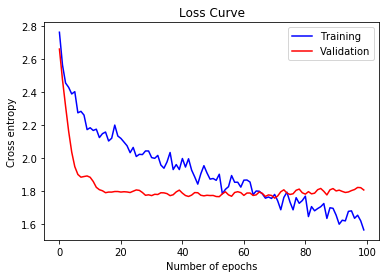

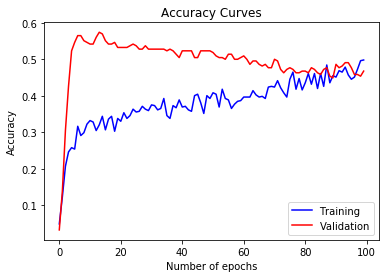

In [111]:
plt.figure()
plt.plot(train_loss, color='b', label='Training')
plt.plot(valid_loss, color='r', label='Validation')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Number of epochs')
plt.ylabel('Cross entropy')

plt.figure()
plt.plot(train_acc, color='b', label='Training')
plt.plot(valid_acc, color='r', label='Validation')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')